In [2]:
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install rasterstats
import rasterstats
import pandas as pd
import geopandas as gpd
import glob
import rasterio
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 4]

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Use rasterstats to access and analyze AGB VRT

* Select the raster VRT for zonal stats
* Build dictionary for each set of input
    * input zones, input regions that contains zones of interest, VRT of COGs
* Select a dictionary to run
    * verify you have the input info you want
* Select regions of interest with a general box; make a list of individual region geodataframes
    * verify the input are in same CRS
    * verify you have the zones you want
* Loop over regions of interest, returning zonal stats for all zones in region


### Specify the raster VRT for zonal stats

In [3]:
vrt_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt'
RASTER_DATASET_ID = 'biomass_prelim'

### Build dictionary for each set of input

In [4]:
ZONAL_STATS_DICT = {'ZONE_NAME':'','ZONE_FN':'','REGION_NAME':'','REGION_FN':'','RASTER_NAME':'','RASTER_FN':''}
ZONAL_STATS_DICT_LIST = [
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': RASTER_DATASET_ID,
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'
    },
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'boreal_na',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson',
            'REGION_SEARCH_COL':'REALM',
            'REGION_SEARCH_STR':'NA',
            'RASTER_DATASET_ID': RASTER_DATASET_ID,
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'
    },
    {
            'ZONE_NAME': 'hybas_lev06',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': RASTER_DATASET_ID,
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb'
    },
    {
            'ZONE_NAME': 'hybas_lev07',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev07_v1c.gpkg',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev04_v1c.gpkg',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': RASTER_DATASET_ID,
            'RASTER_FN': vrt_fn,
            'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb/output'
    },
]


### Select a dictionary to run

In [5]:
ZONAL_STATS_DICT = ZONAL_STATS_DICT_LIST[3]
ZONAL_STATS_DICT

{'ZONE_NAME': 'hybas_lev07',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev07_v1c.gpkg',
 'REGION_NAME': 'above',
 'REGION_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev04_v1c.gpkg',
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': 'Region',
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt',
 'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb/output'}

### Select regions of interest with a general box; make a list of individual region geodataframes
* indiv region gdfs are needed so you can look over them

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 224 entries, 0 to 814
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   HYBAS_ID   224 non-null    int64   
 1   NEXT_DOWN  224 non-null    int64   
 2   NEXT_SINK  224 non-null    int64   
 3   MAIN_BAS   224 non-null    int64   
 4   DIST_SINK  224 non-null    float64 
 5   DIST_MAIN  224 non-null    float64 
 6   SUB_AREA   224 non-null    float64 
 7   UP_AREA    224 non-null    float64 
 8   PFAF_ID    224 non-null    int64   
 9   SIDE       224 non-null    object  
 10  LAKE       224 non-null    int64   
 11  ENDO       224 non-null    int64   
 12  COAST      224 non-null    int64   
 13  ORDER      224 non-null    int64   
 14  SORT       224 non-null    int64   
 15  geometry   224 non-null    geometry
dtypes: float64(4), geometry(1), int64(10), object(1)
memory usage: 29.8+ KB


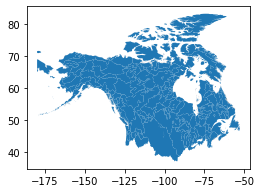

In [6]:
vector_gdf = gpd.read_file(ZONAL_STATS_DICT['REGION_FN']).cx[-180:-45,45:90]
vector_gdf.info()
vector_gdf.plot()

geoms_list = []
zone_name_list = []
poly_list = []
gdf_list = []
zone_field_name = 'HYBAS_ID'

for idx in vector_gdf.index:
    #print(idx)
    geom =  vector_gdf.loc[idx].geometry
    zonename =  vector_gdf.loc[idx][zone_field_name]
    
    if geom not in geoms_list:
        #gpd.GeoSeries(geom).plot()
        geoms_list.append(geom)
        zone_name_list.append(zonename)
        poly_list.append(gpd.GeoSeries(geom))
        gdf_list.append(gpd.GeoDataFrame(geometry=gpd.GeoSeries(geom), crs=vector_gdf.crs))

In [7]:
len(gdf_list)

224

#### Test: Update the dictionary with region of interest

{'ZONE_NAME': 'hybas_lev07',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev07_v1c.gpkg',
 'REGION_NAME': 'hybas_lev04_8040007030',
 'REGION_FN':                                             geometry
 0  MULTIPOLYGON (((-161.70000 66.99167, -161.6840...,
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': None,
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt',
 'OUTPUT_DIR': '/projects/my-public-bucket/analyze_agb/output'}

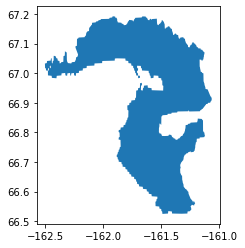

In [8]:
%matplotlib inline
#plt.subplots(figsize=(5,5))

# Example for a single region
IDX=24

gdf_list[IDX].plot()

ZONAL_STATS_DICT.update({'REGION_FN': gdf_list[IDX], 'REGION_SEARCH_STR': None, 'REGION_NAME': f"hybas_lev04_{zone_name_list[IDX]}" })
ZONAL_STATS_DICT

In [11]:
ZONAL_STATS_DICT['REGION_FN'].to_crs(4326).geometry

0    MULTIPOLYGON (((-161.70000 66.99167, -161.6840...
Name: geometry, dtype: geometry

In [12]:
import rioxarray
import fiona

covar_vrt_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.esa_worldcover_v100_2020.wwf_boreal_america.vrt'
vrt_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt'
# open the rasters
rds1 = rioxarray.open_rasterio(covar_vrt_fn)
rds2 = rioxarray.open_rasterio(vrt_fn)



In [20]:
#rds1.crs
rds1.rio.crs

CRS.from_epsg(4326)

In [ ]:
rds1_clipped = rds1.rio.clip(ZONAL_STATS_DICT['REGION_FN'].geometry, ZONAL_STATS_DICT['REGION_FN'].crs)

## Loop over regions of interest, returning zonal stats for all zones in region

In [19]:
%%time
for i in range(223, len(gdf_list)):
    
    # Provide a masked dataset to dictionary?
    
    ZONAL_STATS_DICT.update({'REGION_FN': gdf_list[i], 'REGION_SEARCH_STR': None, 'REGION_NAME': f"hybas_lev04_{zone_name_list[i]}" })
    
    # Some regions could have 0 zones that overlap the raster, so need to continue instead of fail
    try:
        z = ExtractUtils.get_raster_zonalstats(ZONAL_STATS_DICT, DEBUG=False)
        #ax = z.to_crs(4326).plot('median', cmap='viridis', legend=True, vmin=0, vmax=75)
        #print(ax)
    except:
        print(f"Zonal stats failed; No {ZONAL_STATS_DICT['ZONE_NAME']} zones in {ZONAL_STATS_DICT['REGION_NAME']} intersect raster?")
        continue

# of hybas_lev07 zones in hybas_lev04_7040074540 for zonal stats:	18
Current time:	202204251243
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev07
REGION:		hybas_lev04_7040074540
Saving to:	/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev07.hybas_lev04_7040074540.gpkg


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Zonal stats failed; No hybas_lev07 zones in hybas_lev04_7040074540 intersect raster?
CPU times: user 13.8 s, sys: 1.39 s, total: 15.2 s
Wall time: 39.4 s


## Examine output

In [44]:
files = glob.glob('/projects/my-public-bucket/analyze_agb/output/zonal.biomass_prelim.hybas_lev07.hybas_lev04_*.gpkg')
len(files)

223

In [45]:
zonal_gdf = pd.concat([gpd.read_file(f) for f in files])

above_domain_fn = '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp'
above_domain_gdf = gpd.read_file(above_domain_fn)#.cx[-180:-150, 50:75]

with rasterio.open(ZONAL_STATS_DICT['RASTER_FN'], mode='r') as src:
    raster_crs = src.crs
    
zonal_gdf.set_crs(raster_crs, allow_override=True, inplace=True)
zonal_gdf.crs

<Projected CRS: PROJCS["unknown",GEOGCS["NAD83",DATUM["North_Ameri ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
plt.rcParams['figure.figsize'] = [10, 5]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
canada = world[world.name == 'Canada']
canada_alaska = pd.concat([alaska, canada])
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')

ax = canada_alaska.cx[-170:-50,50:90].to_crs(above_domain_gdf.crs).boundary.plot(color='black', linewidth=0.25)
ax = boreal_gdf.cx[-180:-50,50:90].to_crs(above_domain_gdf.crs).boundary.plot(color='black', ax=ax)

zonal_gdf.to_crs(above_domain_gdf.crs).plot('total_Mg', cmap='gist_earth_r', legend=True, vmin=0, vmax=2000, ax=ax)

ValueError: Image size of 431x70563 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x360 with 1 Axes>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddb8c1cc90>]],
      dtype=object)

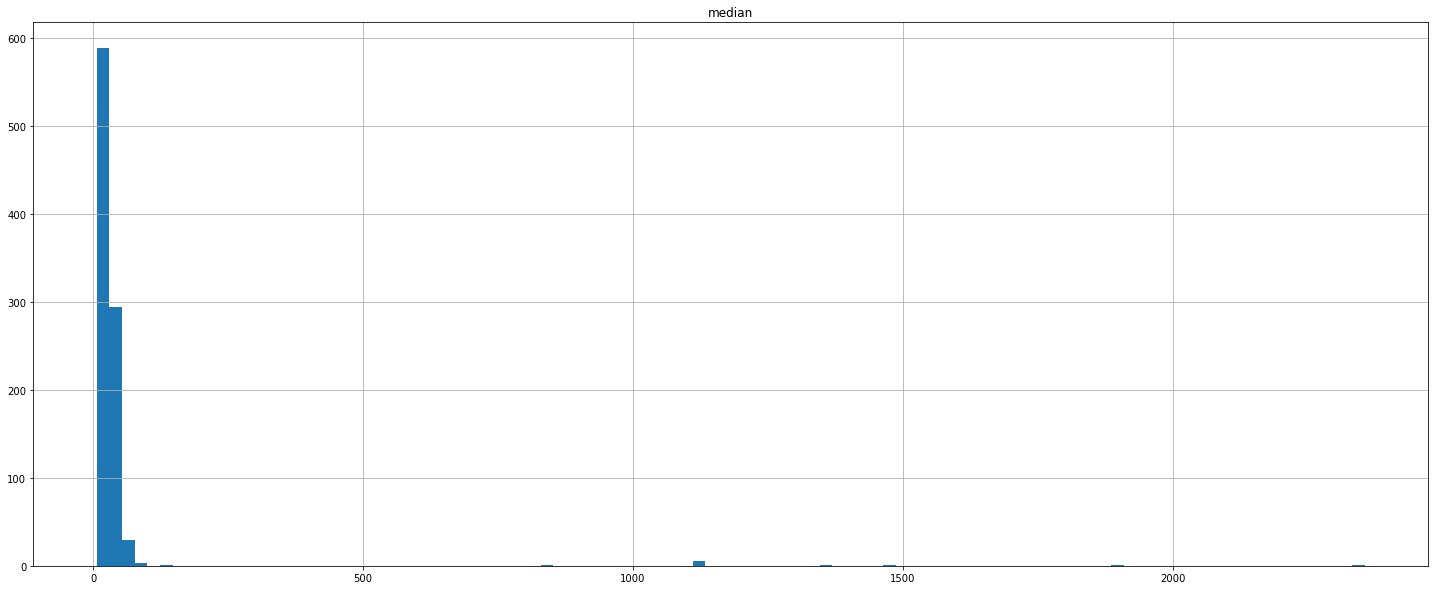

In [13]:
z.hist('median', bins=100)

### Merge all hydrobasins of a given level

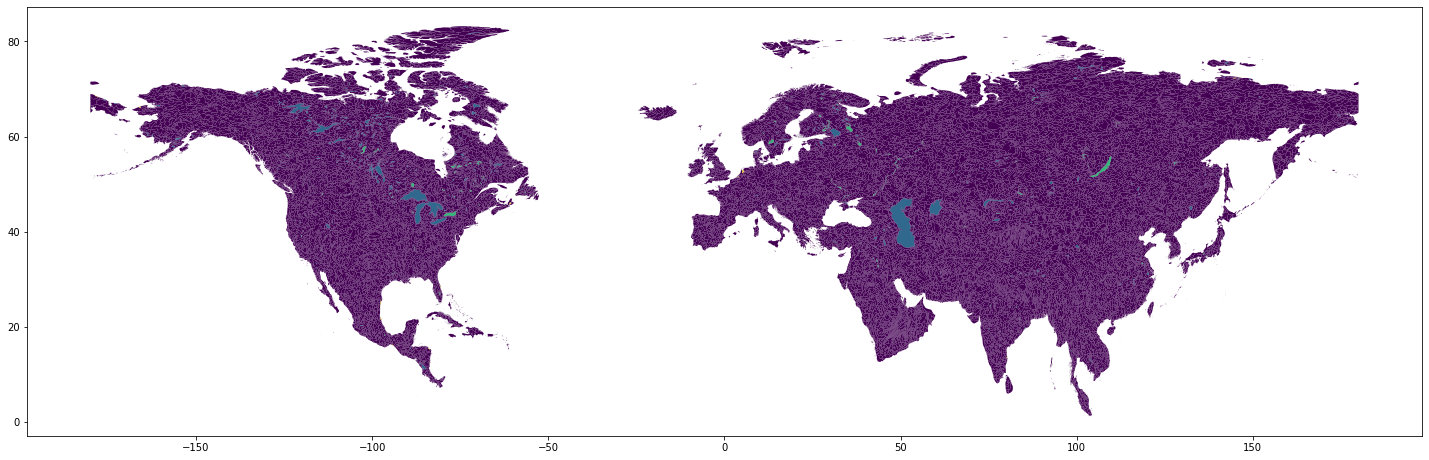

In [14]:
hybas_lev06 = pd.concat([gpd.read_file(f) for f in glob.glob('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_*_lev07_v1c.shp')])
hybas_lev06.plot(column='LAKE')
hybas_lev06.to_file('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev07_v1c.gpkg', driver='GPKG')

#### Unzip hydrobasins after wget
* wget https://data.hydrosheds.org/file/hydrobasins/customized_with_lakes/hybas_lake_gr_lev01-12_v1c.zip

In [15]:
import zipfile
zipdir = '/projects/my-public-bucket/analyze_agb/hydrobasins'
files = glob.glob(f'{zipdir}/*_as_*.zip')
for f in files:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall(zipdir)